<a href="https://colab.research.google.com/github/Pengjp/gene_research/blob/master/custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import keras
from tf_poly import TfPoly
import numpy as np
import math
import seaborn as sns, numpy as np
from scipy import stats
from numpy import hstack
from numpy.random import rand,randint
from numpy.random import randn, exponential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten,Lambda, Input
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from numpy.random import random, choice
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def runif():
    return tf.random.uniform([1], dtype=tf.float64)[0]

def rexp():
    return -tf.math.log(runif())

@tf.function
def gen_gaps(k: int, eta_x: tf.Tensor, eta_c: tf.Tensor, 
             theta=tf.constant(1e-4, dtype=tf.float64), 
             rho=tf.constant(1e-5, dtype=tf.float64)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    eta = TfPoly(x=eta_x, c=tf.math.exp(eta_c))
    R = eta.antiderivative()
    Rinv = R.inverse()
    x = Rinv(rexp())  # initialize x by sampling from prior
    pos = tf.constant(0., dtype=tf.float64)
    j = 0
    ta = tf.TensorArray(tf.float64, size=k + 2)
    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        x = Rinv(z + R(u * x))  # segment height
        pos += rexp() / (x * (theta + rho))  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            pos += rexp() / (x * (theta + rho))  # length to next event
    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    return tf.cast(ret[1:], tf.float32) - tf.cast(ret[:-1], tf.float32)


@tf.function
def gen_generator(c):
    'Generate 10 gaps from distribution induced by c'
    eta = TfPoly(x=[0., 1., np.inf], c=[c])
    return gen_gaps(10, eta.x, eta.c)


# use GAN to learn distribution; hope that embedding distribution concentrates on c=[5,1].
@tf.function
def func(tensor):
  return tf.math.log(tf.map_fn(gen_generator, tensor)) / 20
  # return tf.concatenate([tf.map_fn(gen_generator, tensor), tensor])


d_loss_li=[]
g_loss_li=[]

# First

In [0]:
discriminator = Sequential(
    [
     Input(shape=(1,10)),
     Dense(30),
     LeakyReLU(0.2),
     Dense(50),
     LeakyReLU(0.2),
     Dense(100),
     LeakyReLU(0.2),
     Dense(100),
     LeakyReLU(0.2),
     Flatten(),
     Dense(1, activation='sigmoid')
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 30)             330       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 30)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 50)             1550      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 50)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 100)            5100      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1, 100)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 100)          

In [0]:
latent_dim = 32

generator = Sequential(
    [
      Dense(30, input_shape=[latent_dim], name='fc1'),
      LeakyReLU(alpha = 0.2, name='leaky1'),
      Dense(50, name='fc2', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
      LeakyReLU(alpha = 0.2, name='leaky2'),
      Dense(100, name='fc3', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
      LeakyReLU(alpha = 0.2, name='leaky3'),
      Dense(150, name='fc4'),
      LeakyReLU(alpha = 0.2, name='leaky4'),
      Dense(200),
      LeakyReLU(alpha = 0.2),
      Dense(2),
      LeakyReLU(alpha = 0.2),
      Dense(2, name='fc5'),
      LeakyReLU(alpha = 0.2, name='leaky5'),
      Lambda(func),
      Reshape((1,10))
    ],
    name="generator",
)

In [0]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 30)                990       
_________________________________________________________________
leaky1 (LeakyReLU)           (None, 30)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 50)                1550      
_________________________________________________________________
leaky2 (LeakyReLU)           (None, 50)                0         
_________________________________________________________________
fc3 (Dense)                  (None, 100)               5100      
_________________________________________________________________
leaky3 (LeakyReLU)           (None, 100)               0         
_________________________________________________________________
fc4 (Dense)                  (None, 150)               15

In [0]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
g_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

# Instantiate a loss function.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_examples):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_examples = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_examples, real_examples], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_examples.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)

    tf.debugging.check_numerics(grads[0], 'd gradient nan')

    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)

    tf.debugging.check_numerics(grads[0], 'g gradient nan')

    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_examples

In [0]:
def generate_real_samples(n_samples):
    dataset = tf.math.log([gen_generator(tf.constant([3., 6.])) for _ in  range(n_samples)]) / 20    
    dataset = tf.reshape(dataset, [-1,1,10])
    return dataset

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# def generate_fake_samples(generator, latent_dim, n):
#     # generate points in latent space
#     x_input = generate_latent_points(latent_dim, n)
#     # predict outputs
#     X = generator(x_input)
#     # create class labels
#     y = tf.zeros((n, 1))
#     return X, y

In [0]:
def summarize_performance(epoch, generator, n=1000):
    input_points = generate_latent_points(32, n)

    layer_out=generator.get_layer('leaky5').output
    layer_in=generator.input
    intermediate_model=tf.keras.models.Model(inputs=layer_in,outputs=layer_out)

    X = intermediate_model.predict(input_points)

    sns.distplot(X[:,0], label='first',color='b')
    sns.distplot(X[:,1], label='second',color='r')
    plt.legend()
    plt.legend()
    plt.show()


Start epoch 0
discriminator loss at step 0: 0.71260
adversarial loss at step 0: 0.97454


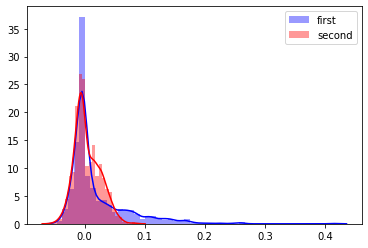

discriminator loss at step 10: 0.70934
adversarial loss at step 10: 0.96253


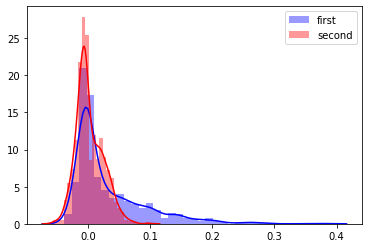

discriminator loss at step 20: 0.70612
adversarial loss at step 20: 0.95389


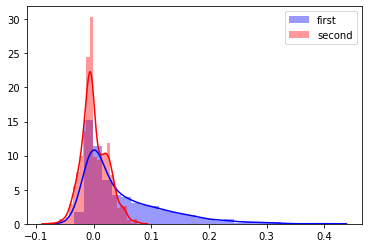

discriminator loss at step 30: 0.70380
adversarial loss at step 30: 0.94596


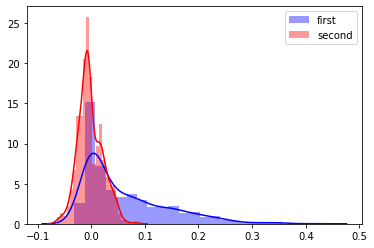

discriminator loss at step 40: 0.70114
adversarial loss at step 40: 0.93748


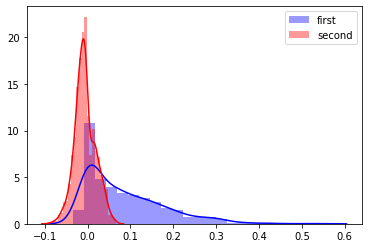

discriminator loss at step 50: 0.69964
adversarial loss at step 50: 0.92773


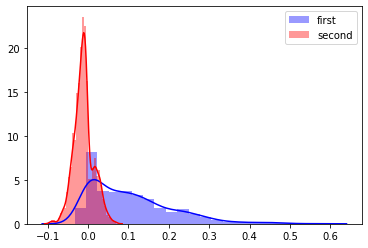

discriminator loss at step 60: 0.69704
adversarial loss at step 60: 0.91994


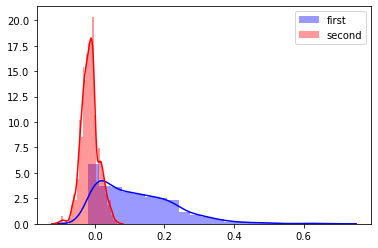

discriminator loss at step 70: 0.69480
adversarial loss at step 70: 0.91105


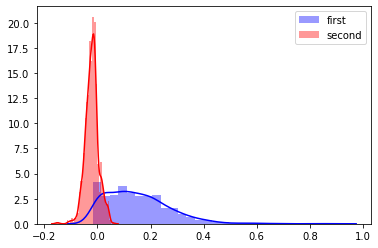

discriminator loss at step 80: 0.69284
adversarial loss at step 80: 0.90316


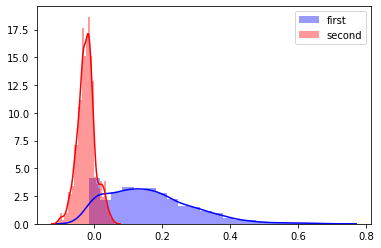

discriminator loss at step 90: 0.69083
adversarial loss at step 90: 0.89197


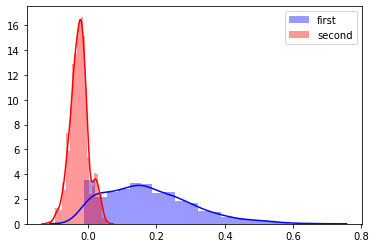


Start epoch 1
discriminator loss at step 0: 0.68849
adversarial loss at step 0: 0.88514


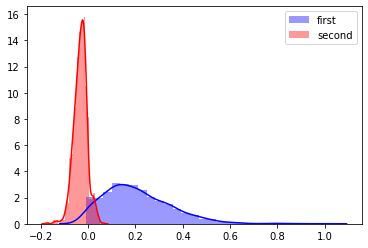

discriminator loss at step 10: 0.68718
adversarial loss at step 10: 0.87397


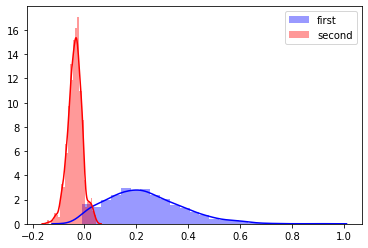

discriminator loss at step 20: 0.68517
adversarial loss at step 20: 0.86419


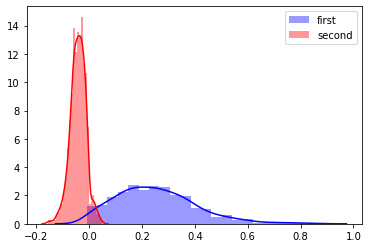

discriminator loss at step 30: 0.68410
adversarial loss at step 30: 0.85566


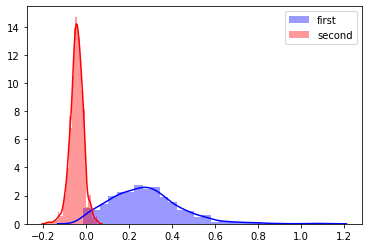

discriminator loss at step 40: 0.68216
adversarial loss at step 40: 0.84786


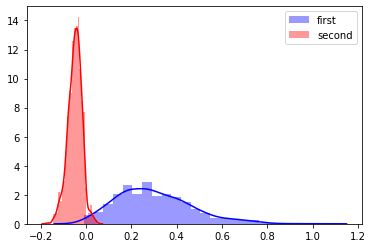

discriminator loss at step 50: 0.68126
adversarial loss at step 50: 0.83747


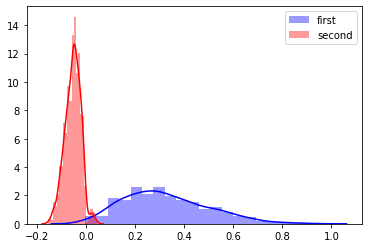

discriminator loss at step 60: 0.68104
adversarial loss at step 60: 0.83027


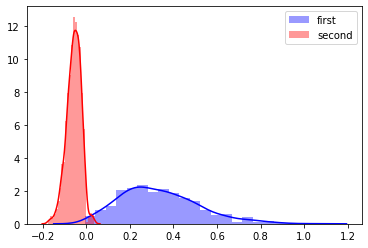

discriminator loss at step 70: 0.68095
adversarial loss at step 70: 0.82264


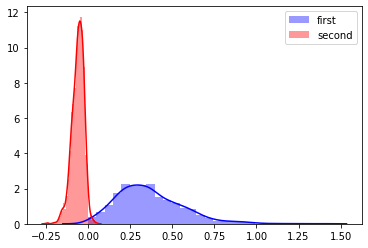

discriminator loss at step 80: 0.67869
adversarial loss at step 80: 0.81854


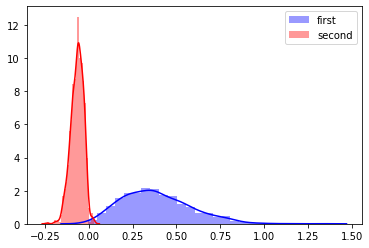

discriminator loss at step 90: 0.67951
adversarial loss at step 90: 0.81285


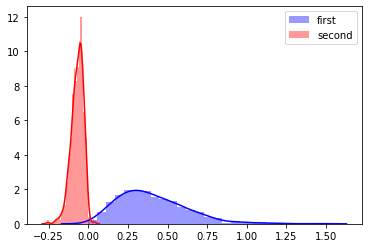


Start epoch 2
discriminator loss at step 0: 0.67923
adversarial loss at step 0: 0.80342


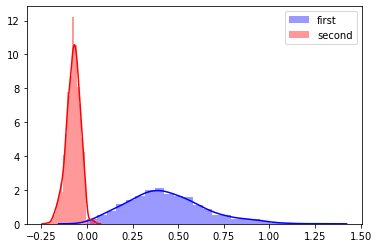

discriminator loss at step 10: 0.67866
adversarial loss at step 10: 0.79982


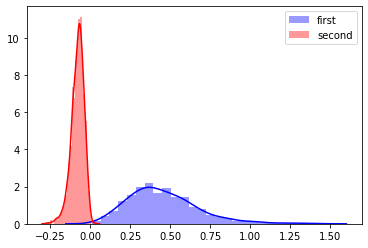

discriminator loss at step 20: 0.67776
adversarial loss at step 20: 0.79647


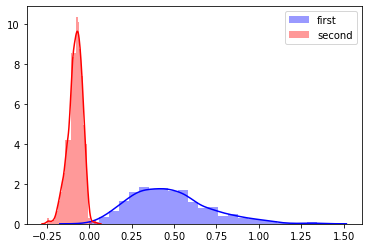

discriminator loss at step 30: 0.67869
adversarial loss at step 30: 0.79202


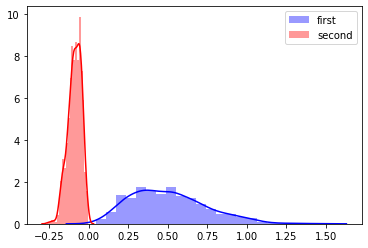

discriminator loss at step 40: 0.67825
adversarial loss at step 40: 0.78920


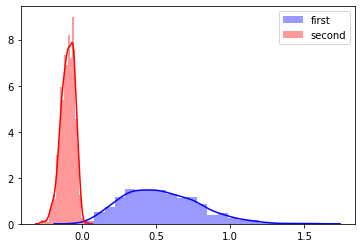

discriminator loss at step 50: 0.67900
adversarial loss at step 50: 0.78941


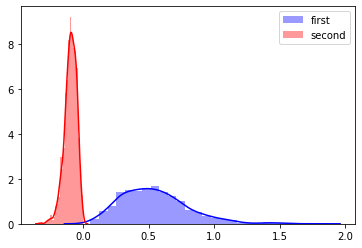

discriminator loss at step 60: 0.67889
adversarial loss at step 60: 0.78566


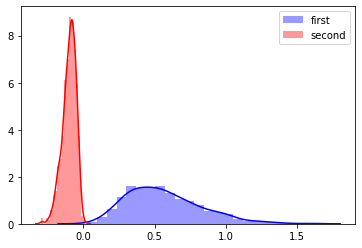

discriminator loss at step 70: 0.67763
adversarial loss at step 70: 0.78692


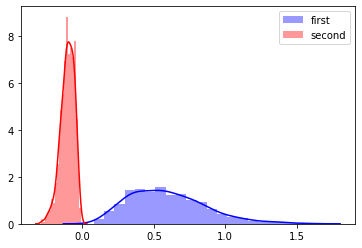

discriminator loss at step 80: 0.67752
adversarial loss at step 80: 0.78443


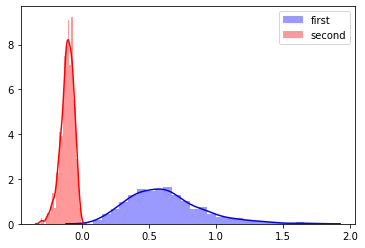

discriminator loss at step 90: 0.67843
adversarial loss at step 90: 0.78683


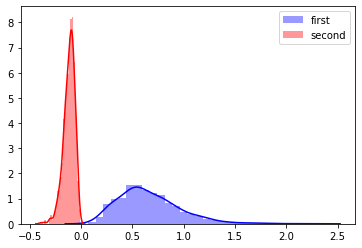


Start epoch 3
discriminator loss at step 0: 0.67749
adversarial loss at step 0: 0.78481


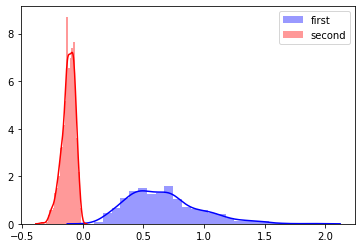

discriminator loss at step 10: 0.67868
adversarial loss at step 10: 0.78528


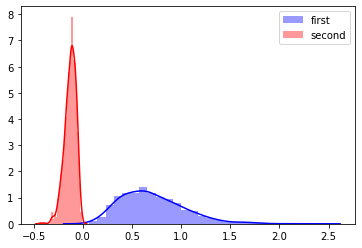

discriminator loss at step 20: 0.67700
adversarial loss at step 20: 0.78734


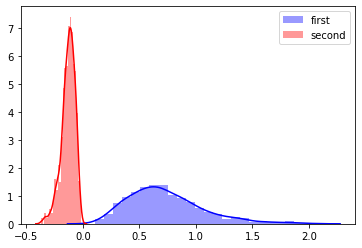

discriminator loss at step 30: 0.67923
adversarial loss at step 30: 0.78588


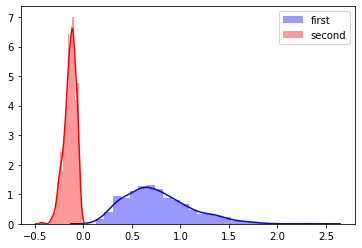

discriminator loss at step 40: 0.67895
adversarial loss at step 40: 0.78743


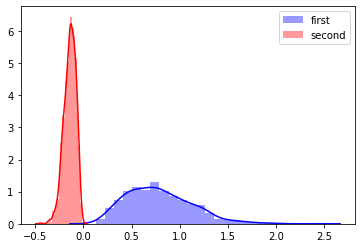

discriminator loss at step 50: 0.68052
adversarial loss at step 50: 0.78870


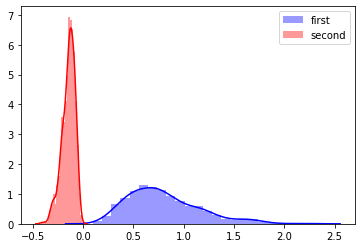

discriminator loss at step 60: 0.67898
adversarial loss at step 60: 0.78646


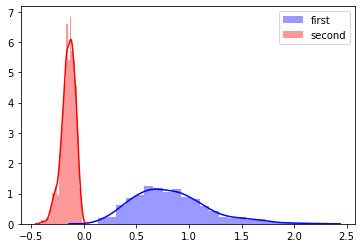

discriminator loss at step 70: 0.67870
adversarial loss at step 70: 0.78619


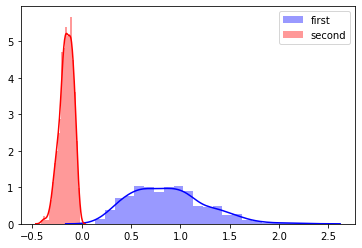

discriminator loss at step 80: 0.67848
adversarial loss at step 80: 0.78916


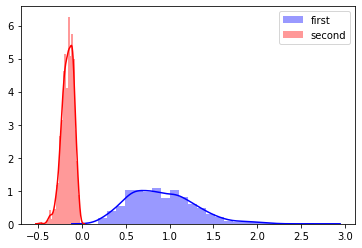

discriminator loss at step 90: 0.67989
adversarial loss at step 90: 0.78774


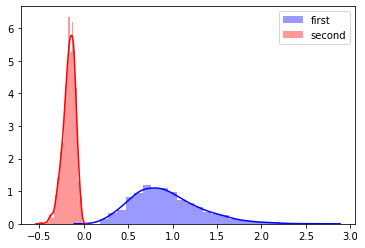


Start epoch 4
discriminator loss at step 0: 0.67944
adversarial loss at step 0: 0.78839


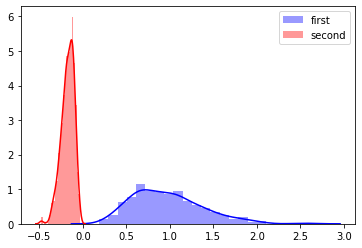

discriminator loss at step 10: 0.67915
adversarial loss at step 10: 0.78797


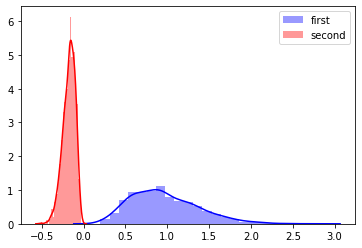

discriminator loss at step 20: 0.67836
adversarial loss at step 20: 0.79014


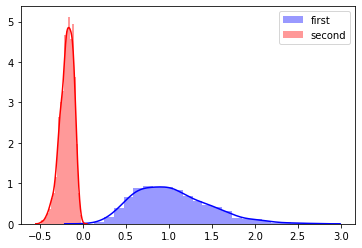

discriminator loss at step 30: 0.68029
adversarial loss at step 30: 0.78997


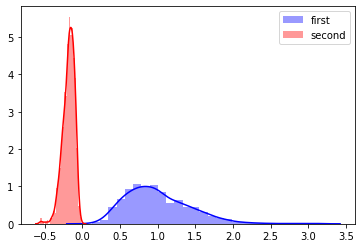

discriminator loss at step 40: 0.67966
adversarial loss at step 40: 0.78816


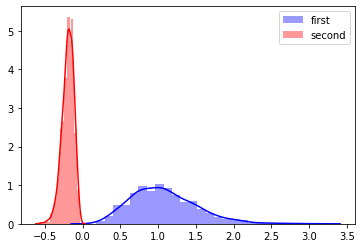

discriminator loss at step 50: 0.68028
adversarial loss at step 50: 0.78766


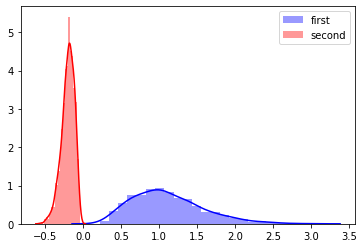

discriminator loss at step 60: 0.67990
adversarial loss at step 60: 0.78819


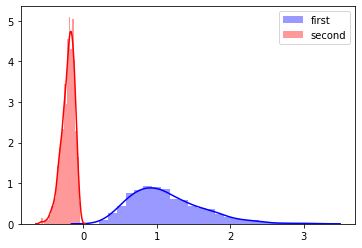

discriminator loss at step 70: 0.68031
adversarial loss at step 70: 0.78882


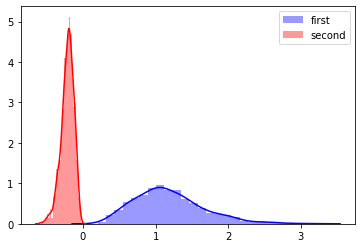

discriminator loss at step 80: 0.68102
adversarial loss at step 80: 0.78618


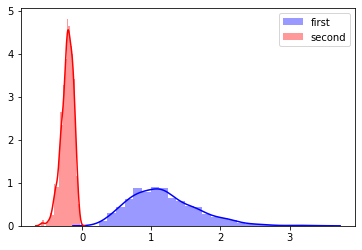

discriminator loss at step 90: 0.67855
adversarial loss at step 90: 0.78827


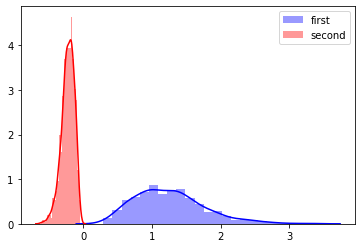


Start epoch 5
discriminator loss at step 0: 0.67976
adversarial loss at step 0: 0.78695


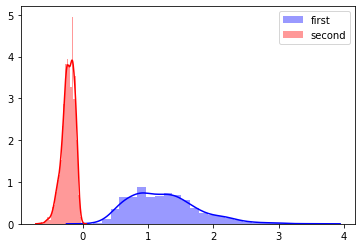

discriminator loss at step 10: 0.68053
adversarial loss at step 10: 0.78944


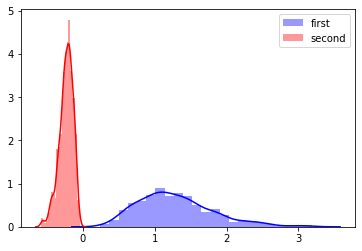

discriminator loss at step 20: 0.67999
adversarial loss at step 20: 0.78876


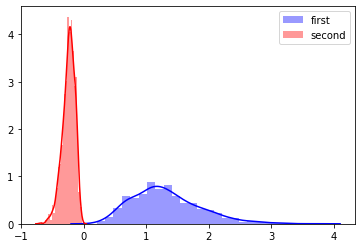

discriminator loss at step 30: 0.68072
adversarial loss at step 30: 0.78829


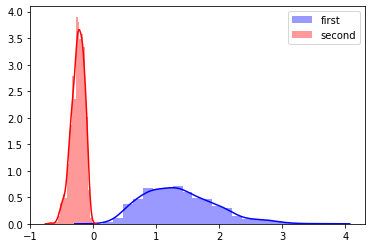

discriminator loss at step 40: 0.68141
adversarial loss at step 40: 0.78802


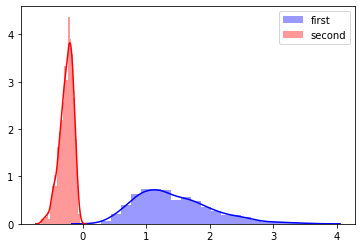

discriminator loss at step 50: 0.68090
adversarial loss at step 50: 0.78675


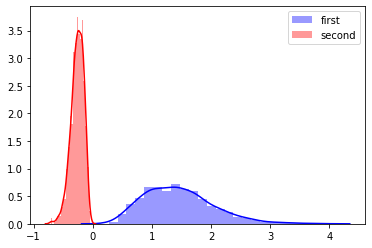

discriminator loss at step 60: 0.68102
adversarial loss at step 60: 0.78677


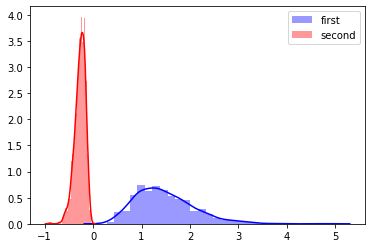

discriminator loss at step 70: 0.68129
adversarial loss at step 70: 0.78623


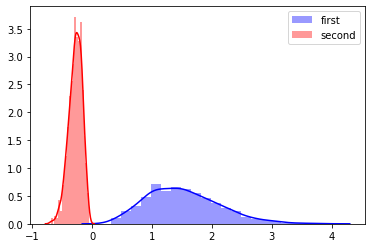

discriminator loss at step 80: 0.68224
adversarial loss at step 80: 0.78840


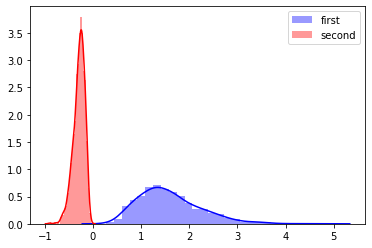

discriminator loss at step 90: 0.68071
adversarial loss at step 90: 0.78938


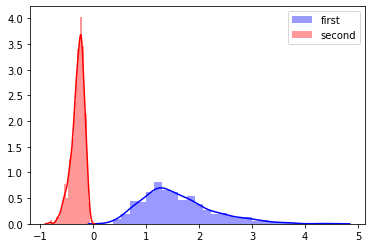


Start epoch 6
discriminator loss at step 0: 0.68059
adversarial loss at step 0: 0.78853


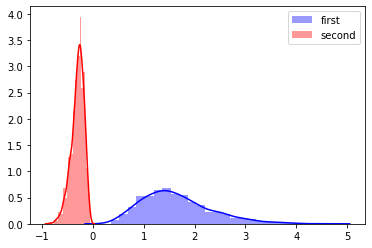

discriminator loss at step 10: 0.68310
adversarial loss at step 10: 0.79091


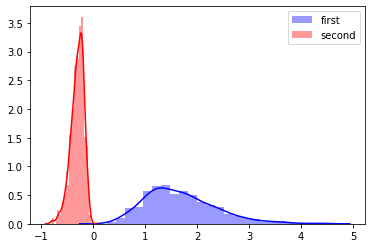

discriminator loss at step 20: 0.68204
adversarial loss at step 20: 0.79150


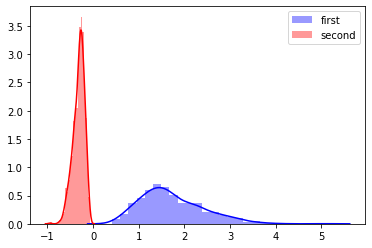

discriminator loss at step 30: 0.68075
adversarial loss at step 30: 0.78853


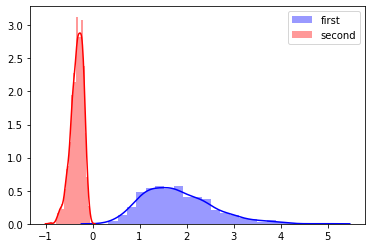

discriminator loss at step 40: 0.68269
adversarial loss at step 40: 0.78829


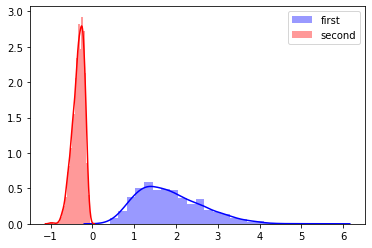

discriminator loss at step 50: 0.68197
adversarial loss at step 50: 0.78995


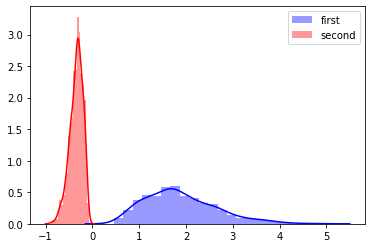

discriminator loss at step 60: 0.68315
adversarial loss at step 60: 0.78473


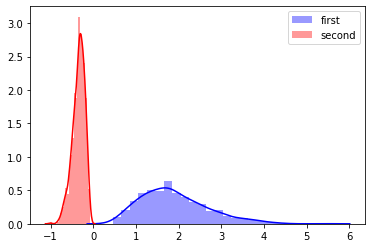

discriminator loss at step 70: 0.68290
adversarial loss at step 70: 0.78919


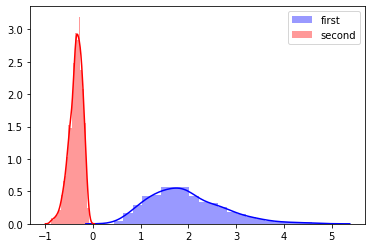

discriminator loss at step 80: 0.68264
adversarial loss at step 80: 0.78718


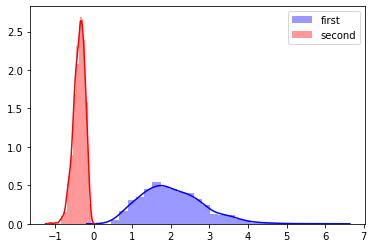

discriminator loss at step 90: 0.68435
adversarial loss at step 90: 0.78688


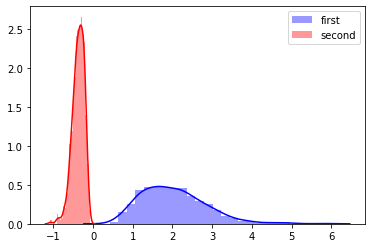


Start epoch 7
discriminator loss at step 0: 0.68318
adversarial loss at step 0: 0.78585


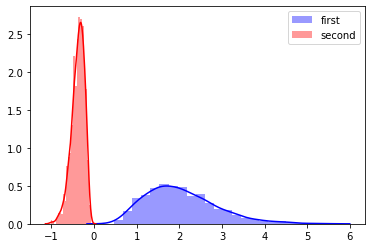

discriminator loss at step 10: 0.68501
adversarial loss at step 10: 0.78256


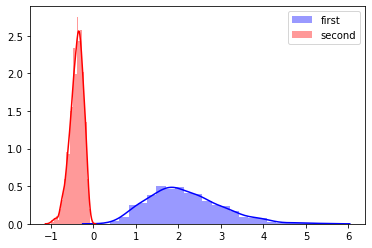

discriminator loss at step 20: 0.68387
adversarial loss at step 20: 0.78254


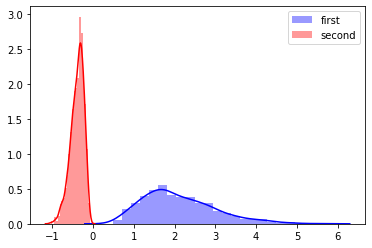

discriminator loss at step 30: 0.68460
adversarial loss at step 30: 0.78189


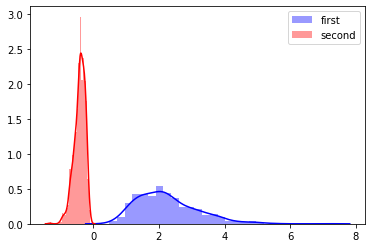

discriminator loss at step 40: 0.68326
adversarial loss at step 40: 0.78123


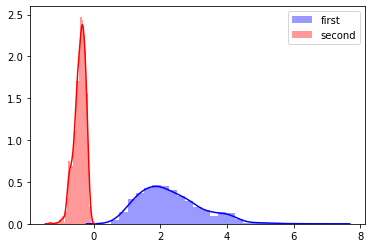

discriminator loss at step 50: 0.68455
adversarial loss at step 50: 0.78253


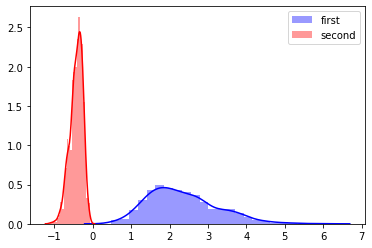

discriminator loss at step 60: 0.68583
adversarial loss at step 60: 0.78067


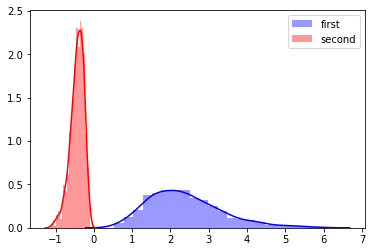

discriminator loss at step 70: 0.68642
adversarial loss at step 70: 0.77248


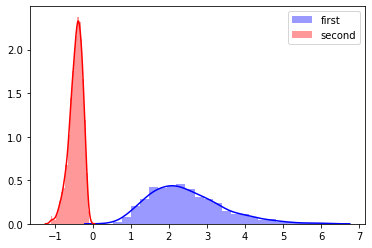

discriminator loss at step 80: 0.68570
adversarial loss at step 80: 0.78086


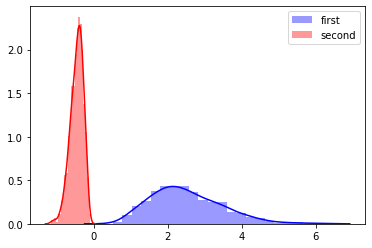

discriminator loss at step 90: 0.68886
adversarial loss at step 90: 0.77390


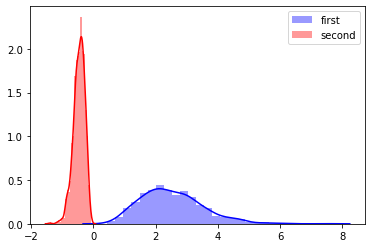


Start epoch 8
discriminator loss at step 0: 0.68557
adversarial loss at step 0: 0.76907


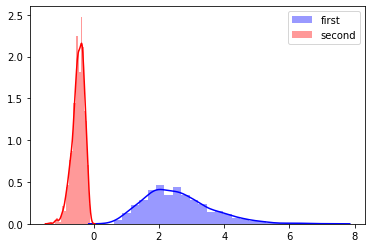

discriminator loss at step 10: 0.68809
adversarial loss at step 10: 0.76753


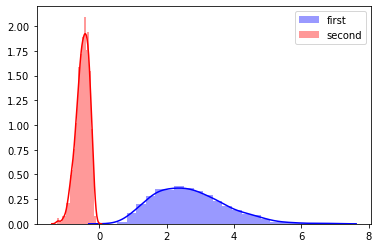

discriminator loss at step 20: 0.68892
adversarial loss at step 20: 0.76370


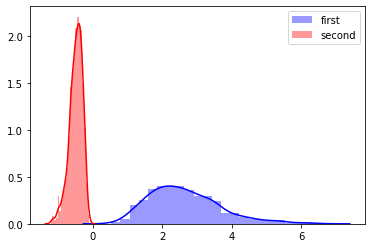

discriminator loss at step 30: 0.68967
adversarial loss at step 30: 0.76378


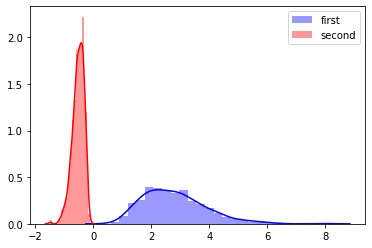

discriminator loss at step 40: 0.68799
adversarial loss at step 40: 0.75900


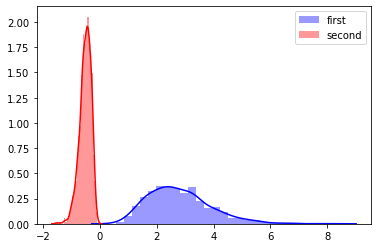

discriminator loss at step 50: 0.68715
adversarial loss at step 50: 0.75481


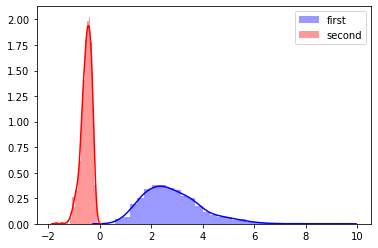

discriminator loss at step 60: 0.68868
adversarial loss at step 60: 0.75701


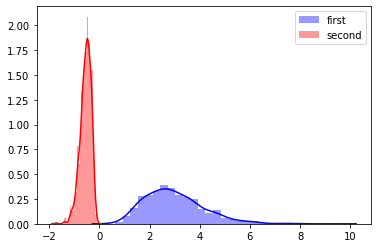

discriminator loss at step 70: 0.68905
adversarial loss at step 70: 0.75237


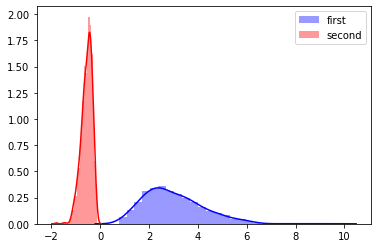

discriminator loss at step 80: 0.69078
adversarial loss at step 80: 0.74966


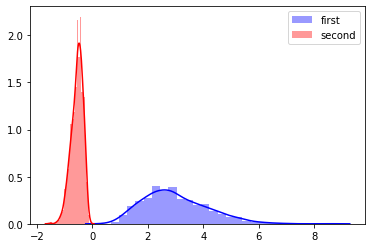

discriminator loss at step 90: 0.69251
adversarial loss at step 90: 0.74310


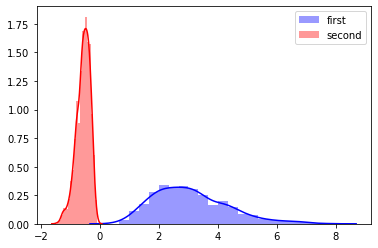


Start epoch 9
discriminator loss at step 0: 0.68860
adversarial loss at step 0: 0.73786


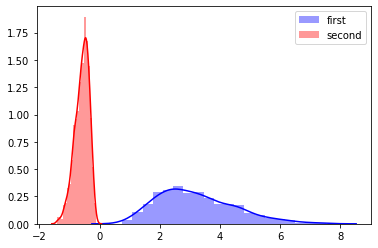

discriminator loss at step 10: 0.69229
adversarial loss at step 10: 0.73788


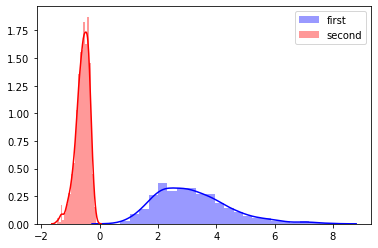

discriminator loss at step 20: 0.69254
adversarial loss at step 20: 0.72954


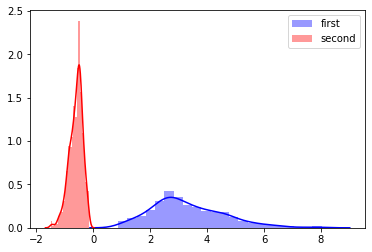

discriminator loss at step 30: 0.69315
adversarial loss at step 30: 0.72283


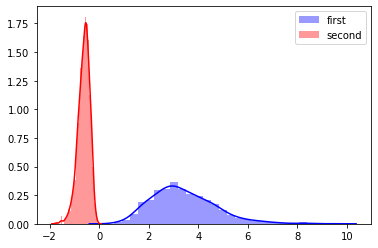

discriminator loss at step 40: 0.69229
adversarial loss at step 40: 0.72145


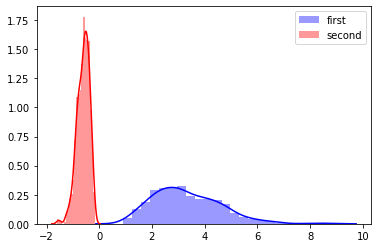

InvalidArgumentError: ignored

In [0]:
import os

epochs = 1000
batch_size = 128

with tf.device('/GPU:0'):
  for epoch in range(epochs):
      print("\nStart epoch", epoch)

      for step in range(100):
          # Train the discriminator & generator on one batch of real images.
          real_images = generate_real_samples(batch_size)
          d_loss, g_loss, generated_images = train_step(real_images)
          
          tf.debugging.check_numerics(d_loss, 'd loss nan')
          tf.debugging.check_numerics(g_loss, 'g loss nan')

          # Logging.
          if step % 10 == 0:
              d_loss_li.append(d_loss)
              g_loss_li.append(g_loss)
              # Print metrics
              print("discriminator loss at step %d: %.5f" % (step, d_loss))
              print("adversarial loss at step %d: %.5f" % (step, g_loss))

              summarize_performance(step, generator, 1000)


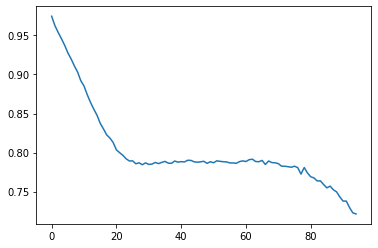

In [0]:
plt.plot(range(len(g_loss_li)), np.array(g_loss_li))

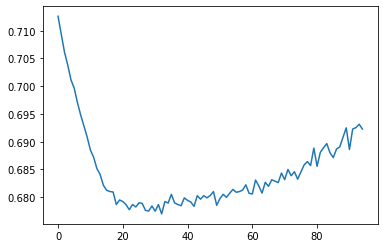

In [0]:
plt.plot(range(len(d_loss_li)), np.array(d_loss_li))

# Second

In [0]:
discriminator = Sequential(
    [
     Input(shape=(1,10)),
     Dense(10),
     LeakyReLU(0.2),
     Dense(30),
     LeakyReLU(0.2),
     Dense(50),
     LeakyReLU(0.2),
     Dense(100),
     LeakyReLU(0.2),
     Dense(150),
     LeakyReLU(0.2),
     Dense(200),
     LeakyReLU(0.2),
     Flatten(),
     Dense(1, activation='sigmoid')
    ],
    name="discriminator",
)

latent_dim = 128

generator = Sequential(
    [
      Dense(30, input_shape=[latent_dim], name='fc1'),
      LeakyReLU(alpha = 0.2, name='leaky1'),
      Dense(50, name='fc2', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
      LeakyReLU(alpha = 0.2, name='leaky2'),
      Dense(100, name='fc3', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
      LeakyReLU(alpha = 0.2, name='leaky3'),
      Dense(150, name='fc4'),
      LeakyReLU(alpha = 0.2, name='leaky4'),
      Dense(200),
      LeakyReLU(alpha = 0.2),
      Dense(2),
      LeakyReLU(alpha = 0.2),
      Dense(2, name='fc5'),
      LeakyReLU(alpha = 0.2, name='leaky5'),
      Lambda(func),
      Reshape((1,10))
    ],
    name="generator",
)

In [0]:
def summarize_performance(epoch, generator, n=500):
    input_points = generate_latent_points(latent_dim, n)

    layer_out=generator.get_layer('leaky5').output
    layer_in=generator.input
    intermediate_model=tf.keras.models.Model(inputs=layer_in,outputs=layer_out)

    X = intermediate_model.predict(input_points)

    sns.distplot(X[:,0], label='first',color='b')
    sns.distplot(X[:,1], label='second',color='r')
    plt.legend()
    plt.legend()
    plt.show()


Start epoch 0
discriminator loss at step 0: 0.71058
adversarial loss at step 0: 0.96924


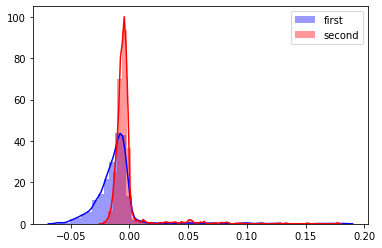

InvalidArgumentError: ignored

In [0]:
import os

epochs = 1000
batch_size = 256

d_loss_li=[]
g_loss_li=[]

d_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00002)
g_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

with tf.device('/GPU:0'):
  for epoch in range(epochs):
      print("\nStart epoch", epoch)

      for step in range(200):
          # Train the discriminator & generator on one batch of real images.
          real_images = generate_real_samples(batch_size)
          d_loss, g_loss, generated_images = train_step(real_images)
          tf.debugging.check_numerics(d_loss, 'd loss nan')
          tf.debugging.check_numerics(g_loss, 'g loss nan')

          # Logging.
          if step % 50 == 0:
              d_loss_li.append(d_loss)
              g_loss_li.append(g_loss)
              # Print metrics
              print("discriminator loss at step %d: %.5f" % (step, d_loss))
              print("adversarial loss at step %d: %.5f" % (step, g_loss))

              summarize_performance(step, generator, 1000)
